## Step 0. Library import

In [1]:
!pip install flopy

# Ejemplo de flujo en 1D en MODFLOW6.

https://modflow6.readthedocs.io/en/latest/

**One-dimensional steady flow with transport**

* This problem corresponds to the first problem presented in the MOC3D report Konikow 1996, involving the transport of a dissolved constituent in a steady, one-dimensional flow field.
* An analytical solution for this problem is given by \cite{wexler1992}.
* This example is simulated with the GWT Model in \mf, which receives flow information from a separate simulation with the GWF Model in \mf.
* Results from the GWT Model are compared with the results from the \cite{wexler1992} analytical solution.

The parameters used for this problem are listed in table~\ref{tab:ex-gwt-moc3d-p01-01}.  The model grid for this problem consists of one layer, 120 rows, and 1 columns.  The top for each cell is assigned a value of 1.0 $cm$ and the bottom is assigned a value of zero.  DELR is set to 1.0 $cm$ and DELC is specified with a constant value of 0.1 $cm$.  The simulation consists of one stress period that is 120 $s$ in length, and the stress period is divided into 240 equally sized time steps.  By using a uniform porosity value of 0.1, a velocity value of 0.1 $cm/s$ results from the injection of water at a rate of 0.001 $cm^3/s$ into the first cell.  The last cell is assigned a constant head with a value of zero, though this value is not important as the cells are marked as being confined.  The concentration of the injected water is assigned a value of 1.0, and any water that leaves through the constant-head cell leaves with the simulated concentration of the water in that last cell.   Advection is solved using the TVD scheme to reduce numerical dispersion.

|   |   |   |
|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---:||Number of periods |1| | `nper` ||Number of layers |1| | `nlay` ||Number of rows |1| | `nrow` ||Number of columns |122| | `ncol` ||Length of system |12.0| cm ||Column width |0.1| cm ||Row width |0.1| cm ||Top of the model |1.0| cm ||Layer bottom elevation (cm) |0| cm ||Specific discharge |0.1| cm s$^{-1}$ ||Hydraulic conductivity |0.01| cm s$^{-1}$ ||Porosity of mobile domain |0.1| unitless ||Simulation time |120.0| s ||Source concentration |1.0| unitless ||Initial concentration |0.0| unitless |

<img src="./figures/modflow01.png" width=300px hspace="5" vspace="5" style="float: left;"/>

Figure 2. Schematic diagram showing several common ways in which the groundwater flow (GWF) and groundwatertransport (GWT) models can be configured within a simulation. The common use case depicted in (A) consists of a single    GWF model that is solved by a Numerical Solution. From [1]. 

* MODFLOW 6 – Example problems, MODFLOW 6 Development Team, with contributions from Chieh Ying Chen and Mike Toews 02/07/2024. mf6example.spdf.

* [1] Konikow, L. F., Goode, D. J., & Hornberger, G. (1996). A three-dimensional method-of-characteristics solute-transport model (MOC3D). https://doi.org/10.3133/wri964267
* [2] Wexler, E. J. (1992). Analytical solution for one-, two-, and three-dimensional solute transport in ground-water systems with uniform flow; supplemental report; source codes for computer programs and sample data sets. U.S. Geological Survey Open File Report/Open-file Report. https://doi.org/10.3133/ofr9278
* [2] Langevin, C. D., Hughes, J. D., Provost, A. M., Russcher, M. J., & Panday, S. (2023). MODFLOW as a configurable Multi‐Model Hydrologic Simulator. Ground Water. https://doi.org/10.1111/gwat.13351

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Biblioteca y módulos de flopy
import flopy
from flopy.plot.styles import styles

## Step 1. Simulation parameters definition.

In [3]:
#3class mesh()
## Discretization
#nper = 1  # Number of periods
#nlay = 1  # Number of layers
#nrow = 1  # Number of rows
#ncol = 120  # Number of columns
#length_x = delr * nrow
#length_y = 12.0  # Length of system ($cm$)
#length_z =  top - botm
#delr = 0.1  # Column width ($cm$)
#delc = 0.1  # Row width ($cm$)
#top = 1.0  # Top of the model ($cm$)
#botm = 0  # Layer bottom elevation ($cm$)

In [4]:
# Model units
length_units = "centimeters"
time_units = "seconds"

# Model parameters

## Discretization
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 122  # Number of columns
system_length = 12.0  # Length of system ($cm$)
delr = 0.09836065573770492# 0.1 #0.1  # Column width ($cm$) # 12/ 122, system_length / ncol
delc = 0.1  # Row width ($cm$)
top = 1.0  # Top of the model ($cm$)
botm = 0  # Layer bottom elevation ($cm$)

## Physical parameters
specific_discharge = 0.1  # Specific discharge ($cm s^{-1}$)
hydraulic_conductivity = 0.01  # Hydraulic conductivity ($cm s^{-1}$)
porosity = 0.1  # Porosity of mobile domain (unitless)
source_concentration = 1.0  # Source concentration (unitless)
initial_concentration = 0.0  # Initial concentration (unitless)
total_time = 120.0  # Simulation time ($s$)

## Step 2. Path to MODFLOW6 and simulation name

In [5]:
ws = os.getcwd() # Ruta de donde estamos actualmente
mf6_exe = '/home/jovyan/GMMC/WMA/mf6/bin/mf6' # Ejecutable
name = 'flow' # Nombre de la simulación

print(' Ruta hacia el ejecutable de MODFLOW 6 : {} '.format(mf6_exe))
print(' Ruta actual : {}'.format(ws))
print(' Nombre de esta simulación: {}'.format(name))

 Ruta hacia el ejecutable de MODFLOW 6 : /home/jovyan/GMMC/WMA/mf6/bin/mf6 
 Ruta actual : /home/jovyan/GMMC/WMA/notebooks/1_Flujo_mf6_1D
 Nombre de esta simulación: flow


## Step 3. Simulation object

In [6]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=mf6_exe)
print(sim)

sim_name = flow
sim_path = /home/jovyan/GMMC/WMA/notebooks/1_Flujo_mf6_1D
exe_name = /home/jovyan/GMMC/WMA/mf6/bin/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = flow





## Step 4. Time discretization object

<center>
<img src="../figures/time_step.png" width=500px>
</center>
  
The length of a time step is calculated by multiplying the length of the previous time step by TSMULT. 
The length of the first time step, $\Delta t_1$, is related to PERLEN, NSTP, and TSMULT by the relation:
$$
\Delta t_1= \frac{\text{PERLEN}}{\text{NSTP}} \;\; \text{para} \;\; \text{TSMULT} = 1
$$

$$
\Delta t_1= \text{PERLEN} \frac{\text{TSMULT} - 1}{\text{TSMULT}^\text{nstp}-1} \;\; \text{para} \;\; \text{TSMULT} \neq 1
$$

The length of each successive time step is computed as

$$
\Delta t = \Delta t_{old} \text{TSMULT}
$$

where:
* `perlen` (double) is the length of a stress period.
* `nstp` (integer) is the number of time steps in a stress period.
* `tsmult` (double) is the multiplier for the length of successive time steps.
  
Véase: Hughes, J.D., Langevin, C.D., and Banta, E.R., 2017, *Documentation for the MODFLOW 6 framework: U.S. Geological Survey Techniques and Methods*, book 6, chap. A57, 40 p., https://doi.org/10.3133/tm6A57. **Timing Module, pp 10,12**.

In [7]:
tdis_ds = ((total_time, 1, 1.0),) # perlen, nstp, tsmult

In [8]:
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

package_name = flow.tdis
filename = flow.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = flow

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 1, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', '<i8'), ('tsmult', '<f8')]))



## Step 5. IMS object (solution calculation)

In [9]:
ims = flopy.mf6.ModflowIms(sim)
print(ims)

package_name = ims_-1
filename = flow.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = flow




## Step 6. GWF model object (flow)

In [10]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
print(gwf)

name = flow
model_type = gwf6
version = mf6
model_relative_path = .




## Step 7. Space discretization object

In [11]:
print(ncol)

122


In [12]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              length_units=length_units,
                              nlay=nlay,
                              nrow=nrow,
                              ncol=ncol,
                              delr=delr,
                              delc=delc,
                              top=top,
                              botm=botm,
)
print(dis)

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(122)


Block griddata
--------------------
delr
{constant 0.09836065573770492}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0}





In [13]:
dis.data_list

[{internal}
 ('centimeters'),
 ,
 ,
 ,
 ,
 {internal}
 (1),
 {internal}
 (1),
 {internal}
 (122),
 {constant 0.09836065573770492},
 {constant 0.1},
 {constant 1.0},
 {constant 0},
 ]

## Step 8. Initial conditions object

In [14]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=1.0)
print(ic)

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow

Block griddata
--------------------
strt
{constant 1.0}





## Step 9. Node Property Flow (NPF6) Package

In [15]:
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              save_specific_discharge=True,
                              save_saturation=True,
                              icelltype=0,
                              k=hydraulic_conductivity,
)
print(npf)

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow

Block options
--------------------
save_specific_discharge
{internal}
(True)

save_saturation
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.01}





## Step 10. Discharge object 

In [16]:
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]]) 
print(chd)

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow

Block period
--------------------
stress_period_data
{0: <flopy.mf6.data.mfdataplist.PandasListStorage object at 0x7f9d44912b50>}




## Step 11. Wells object

In [17]:
wel_spd = {
    0: [ [(0, 0, 0),
          specific_discharge * delc * delr * top,
          source_concentration]
       ]
}

wel = flopy.mf6.ModflowGwfwel(gwf,
                              stress_period_data=wel_spd,
                              pname="WEL-1",
                              auxiliary=["CONCENTRATION"],
)

print(wel)

package_name = wel-1
filename = flow.wel
package_type = wel
model_or_simulation_package = model
model_name = flow

Block options
--------------------
auxiliary
{internal}
([('auxiliary', 'CONCENTRATION')])


Block period
--------------------
stress_period_data
{0: <flopy.mf6.data.mfdataplist.PandasListStorage object at 0x7f9d4a449790>}




## Step 12. Output object

In [18]:
head_filerecord = f"{name}.hds"
budget_filerecord = f"{name}.bud"
oc = flopy.mf6.ModflowGwfoc(gwf,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print(oc)

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow

Block options
--------------------
budget_filerecord
{internal}
([('flow.bud',)])

head_filerecord
{internal}
([('flow.hds',)])


Block period
--------------------
saverecord
{internal}
([('HEAD', 'ALL', None) ('BUDGET', 'ALL', None)])

printrecord
None




## Step 13. Write Input files.

In [19]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


## Step 14. Run simulation

In [20]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../mf6/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 16:19:58 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall

(True, [])

## Step 15. Postprocessing

In [21]:
flopy.mf6.coordinates.modelgrid

<module 'flopy.mf6.coordinates.modelgrid' from '/opt/conda/lib/python3.11/site-packages/flopy/mf6/coordinates/modelgrid.py'>

In [22]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(os.path.join(ws, head_filerecord)).get_data()

# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(os.path.join(ws, budget_filerecord),
                                  precision='double')
# Obtenemos las velocidades
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [23]:
print(head.shape, '\n', head[0,0])

(1, 1, 122) 
 [12.70653101 12.60978282 12.51303463 12.41628643 12.31953824 12.22279005
 12.12604186 12.02929367 11.93254548 11.83579729 11.7390491  11.64230091
 11.54555272 11.44880453 11.35205634 11.25530815 11.15855996 11.06181177
 10.96506358 10.86831539 10.7715672  10.67481901 10.57807082 10.48132263
 10.38457444 10.28782625 10.19107806 10.09432987  9.99758168  9.90083349
  9.8040853   9.70733711  9.61058892  9.51384073  9.41709254  9.32034435
  9.22359616  9.12684797  9.03009978  8.93335159  8.8366034   8.73985521
  8.64310702  8.54635883  8.44961064  8.35286245  8.25611426  8.15936607
  8.06261788  7.96586969  7.8691215   7.77237331  7.67562512  7.57887693
  7.48212874  7.38538055  7.28863236  7.19188417  7.09513598  6.99838779
  6.9016396   6.80489141  6.70814322  6.61139503  6.51464684  6.41789865
  6.32115046  6.22440227  6.12765408  6.03090589  5.9341577   5.83740951
  5.74066132  5.64391313  5.54716494  5.45041675  5.35366856  5.25692037
  5.16017218  5.06342399  4.9666758  

In [24]:
print(qx.shape, '\n', qx)

(1, 1, 122) 
 [[[0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.00983607 0.00983607 0.00983607 0.00983607 0.00983607
   0.00983607 0.0098

In [25]:
print(delr, ncol, system_length)

0.09836065573770492 122 12.0


In [26]:
12/122

0.09836065573770492

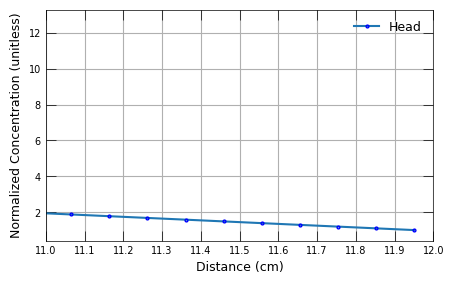

In [27]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'

    x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol)
#
#    x = np.linspace(0.0, system_length, ncol)
    
    plt.figure(figsize=(5,3))
    plt.plot(x[::1], head[0, 0][::1], marker=".", ls ="-", mec="blue", mfc="none", markersize="4", label = 'Head')
    plt.xlim(11, 12)
    plt.xticks(ticks=np.linspace(11,12,11))

#    plt.xticks(ticks=np.linspace(0,system_length,13))
    plt.xlabel("Distance (cm)")
    plt.ylabel("Normalized Concentration (unitless)")
    plt.legend()
    plt.grid()
    plt.show()

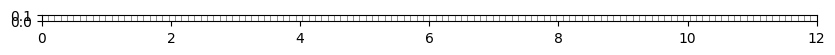

In [28]:

#fig, ax = plt.subplots(1,1, figsize=(10,10))
# Dibujamos la malla (con flopy)
plt.figure(figsize=(10,1.0))
ax = plt.gca()
ax.set_aspect('equal')
pmv0 = flopy.plot.PlotMapView(gwf, ax=ax)
pmv0.plot_grid(colors='dimgray', lw=0.5)
plt.show()

# 